In [122]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")


excludedAttrsByDefault = ["STUDENT ID", "GRADE", "COURSE ID"]
target = "GRADE"

In [ ]:
data = pd.read_csv("./data/DATA.csv", sep=';')
X_train, X_test, y_train, y_test = train_test_split(
    data[data.columns.drop(excludedAttrsByDefault)], data[target], test_size=0.2)

In [123]:
from math import inf, log2


def isSuccess(Y):
    return (Y >= 4) & (Y <= 7)


def getInfoT(T: pd.Series, Y: pd.Series):
    entrophy = 0.0

    succesFreq = len(Y[isSuccess(Y)])
    failedFreq = len(Y) - succesFreq

    if succesFreq == 0 or failedFreq == 0:
        return 0
    entrophy -= succesFreq/len(Y) * log2(succesFreq/len(Y))
    entrophy -= failedFreq/len(Y) * log2(failedFreq/len(Y))

    return entrophy


def getInfoTX(T: pd.Series, Y: pd.Series, attr: str):
    entrophy = 0.0
    signs = np.unique(T[attr])

    for sign in signs:
        Ti = T[T[attr] == sign]
        entrophy += len(Ti)/len(T) * getInfoT(Ti, Y[T[attr] == sign])

    return entrophy


def getSplitInfoX(T: pd.Series, Y: pd.Series, attr: str):
    entrophy = 0.0
    signs = np.unique(T[attr])

    for sign in signs:
        Ti = T[T[attr] == sign]
        entrophy -= len(Ti)/len(T) * log2(len(Ti)/len(T))

    return entrophy


def gainRatio(T: np.array, Y: np.array, attr: str):
    splitInfoX = getSplitInfoX(T, Y, attr)
    if abs(splitInfoX) < np.finfo(float).eps:
        return -inf

    return (getInfoT(T, Y) - getInfoTX(T, Y, attr)) / splitInfoX


def getAttrWithMaxGainRatio(T, Y, attrs: set[str]):
    maxGainRatio = -inf
    attrWithMaxGainRatio = None
    for index, attr in enumerate(list(attrs)):
        gr = gainRatio(T, Y, attr)
        if maxGainRatio < gr:
            maxGainRatio = gr
            attrWithMaxGainRatio = attr

    return attrWithMaxGainRatio


In [142]:
class Node:
    children:dict[str,"Node"]
    parent:("Node" or None)
    attr:str
    value:any
    X:pd.Series
    Y:pd.Series
    def __init__(self,X=None,Y=None,parent=None,children=[],attr=None,value=None):
        self.children = dict().fromkeys(children)
        self.parent = parent
        self.attr = attr
        self.value = value
        self.X = X
        self.Y = Y


    def getattrs(self):
        attrs = set()
        if self.attr is not None:
            attrs.add(self.attr)
        node = self
        while node.parent is not None:
            node = node.parent
            if node.attr is not None:
                attrs.add(node.attr)

        return np.array(attrs)
            

In [143]:
class ClassifierByTree:

    def __init__(self) -> None:
        self.root = Node(None, None, None, [], None, None)

    def learn(self, X, Y, attrSet):
        nodes = [self.root]
        self.root.X = X
        self.root.Y = Y

        i = 0
        while i < len(nodes):
            node = nodes[i]
            i += 1
            x = node.X
            y = node.Y
            if len(y) < 2:
                continue

            attrs = attrSet - node.getattrs()
            resultAttr = getAttrWithMaxGainRatio(x, y, attrs)
            if resultAttr == None:
                continue
            node.attr = resultAttr

            values = np.unique(x[resultAttr])

            for index, value in enumerate(values):
                rowsWithValue = x[resultAttr] == value
                child = Node(x[rowsWithValue], y[rowsWithValue],
                             node, [], None, value)
                nodes.append(child)
                node.children[value] = child

    def proba(self, sample):
        node = self.root
        while node.attr is not None:
            val = sample[node.attr]
            if val not in node.children.keys():
                break
            node = node.children[val]
        X = node.X
        Y = node.Y
        return len(Y[isSuccess(Y)])/len(Y)

    def getRoot(self):
        return self.root


In [147]:
from random import randint
attrsCount = int(len(data)**(1/2))
attrSet = set()
for i in range(attrsCount):
    attr = randint(1, 30)
    if attr in attrSet:
        while attr in attrSet:
            attr = randint(1, 30)

    attrSet.add(attr)

attrSet = set([str(attr) for attr in list(attrSet)])
# print("Random chosen attribues are", attrSet)
attrSet = set([str(attr) for attr in list(range(1,30))])
# attrSet = {'8', '11', '29', '5', '18', '3', '7', '15', '25', '22', '2', '17'}

In [148]:
clf = ClassifierByTree()
clf.learn(X_train, y_train, attrSet)

In [149]:
y_pred = y_test.copy()
rift = 0.5
TP, FP, TN, FN = 0, 0, 0, 0
for index in X_test.index:
    sample = X_test.T[index]
    origin_class = y_test[index]
    pred_class = clf.proba(sample)
    if origin_class >= 4 and pred_class >= rift:
        TP += 1
    if origin_class >= 4 and pred_class < rift:
        FN += 1
    if origin_class <= 3 and pred_class < rift:
        TN += 1
    if origin_class <= 3 and pred_class >= rift:
        FP += 1
    y_pred[index] = pred_class


print(f'count of samples {len(X_test)}\n\tT\tF\nP\t{TP}\t{FP}\nN\t{TN}\t{FN}')
accuracy = (TP+TN)/(TP+FP+TN+FN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
print(f'accuracy is {accuracy}\nprecision is {precision}\nrecall is {recall}')


count of samples 29
	T	F
P	6	3
N	13	7
accuracy is 0.6551724137931034
precision is 0.6666666666666666
recall is 0.46153846153846156


(31, False, 1.0)
(91, True, 1.0)
(100, True, 1.0)
(28, False, 1.0)
(82, True, 1.0)
(87, True, 1.0)
(90, True, 1.0)
(129, False, 1.0)
(99, True, 1.0)
(93, True, 0.4339622641509434)
(71, True, 0.3333333333333333)
(29, True, 0.3333333333333333)
(138, False, 0.18181818181818182)
(104, False, 0.09090909090909091)
(116, False, 0.0)
(64, False, 0.0)
(69, True, 0.0)
(7, False, 0.0)
(5, False, 0.0)
(137, False, 0.0)
(127, False, 0.0)
(67, False, 0.0)
(109, True, 0.0)
(123, False, 0.0)
(140, True, 0.0)
(12, False, 0.0)
(55, False, 0.0)
(77, True, 0.0)
(37, False, 0.0)
16 13


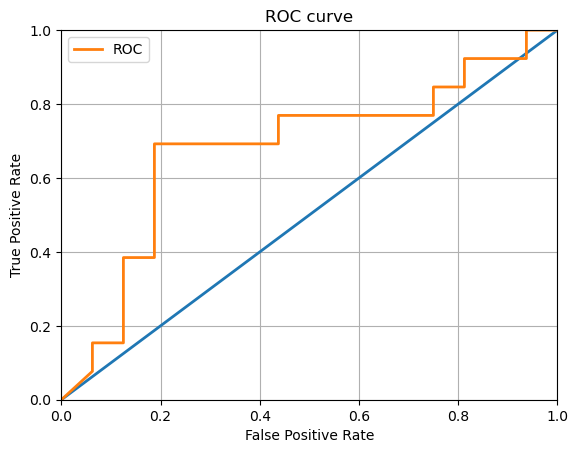

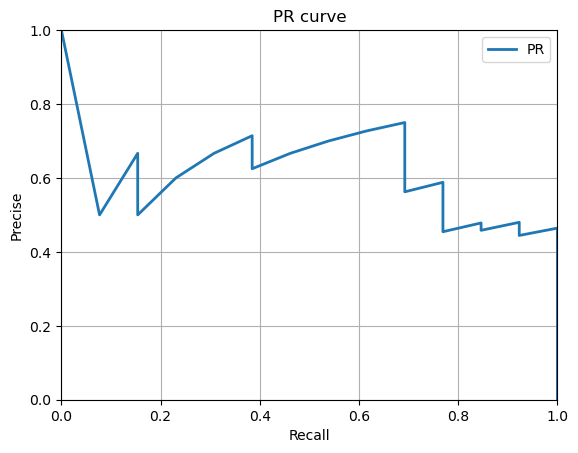

In [152]:
import matplotlib.pyplot as plt

ORIG_CLASS, PRED_CLASS = 1, 2

results = []
for index in y_pred.index:
    results.append((
        index,
        y_test[index] >= 4,
        y_pred[index]
    ))
results.sort(key=lambda x: (x[PRED_CLASS]), reverse=True)
# results.sort(key=lambda x: (x[PRED_CLASS],x[ORIG_CLASS]), reverse=True)


for i in results:
    print(i)


# working convetion
list_precise = [1]
list_recall = [0]
list_tpr = [0]
list_fpr = [0]

number_p = sum([1 if i[ORIG_CLASS] else 0 for i in results])
number_n = sum([1 if not i[ORIG_CLASS] else 0 for i in results])
print(number_n,number_p)
tp = 0
fp = 0
if results[0][ORIG_CLASS]:
    tp = 1
else:
    fp = 1
for i in range(1, number_p+number_n):
    if results[i][ORIG_CLASS]:
        tp += 1
    else:
        fp += 1
    list_precise.append(tp/(tp+fp))
    list_recall.append(tp/number_p)
    list_tpr.append(tp/number_p)
    list_fpr.append(fp/number_n)

# finish working convetion
list_precise.append(0)
list_recall.append(1)
list_tpr.append(1)
list_fpr.append(1)

x = np.array(list_recall)
y = np.array(list_precise)
tpr = np.array(list_tpr)
fpr = np.array(list_fpr)

# draw AUC-ROC
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linewidth=2.0)
plt.plot(fpr, tpr, label='ROC', linewidth=2.0)
plt.grid()

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("ROC curve")
plt.show()

# draw AUC-PR
plt.plot(x, y, label='PR', linewidth=2)
plt.grid()
plt.title("PR curve")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Recall")
plt.ylabel("Precise")
plt.show()
